In [73]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *

## Choose subject and file

In [74]:
task = 'listen'
period = 'post'  
subjects_to_process = ['10']

overwrite = False
keystroke_trigs = 'audio'

In [75]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are
#figure_folder = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_motor/motor_figures'
evokeds_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_ERP_data'
epochs_folder = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data'

with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)

ch_names_64 = ch_names_all[0:64]
ch_names_72 = ch_names_all[0:72]

"""ref_names = ['M1', 'M2']
eog_names = ['EOG1', 'EOG2']"""

downfreq = 128

In [76]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, f'eeg_{task}_{period}_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    all_electrodes = data['all_electrodes']
    events_sv = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


Opening eeg_listen_post_10.mat


In [77]:
#making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})

raw.set_montage('biosemi64')

Creating RawArray with float64 data, n_channels=72, n_times=85120
    Range : 0 ... 85119 =      0.000 ...   664.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/3214231580.py:6: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/3214231580.py:7: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


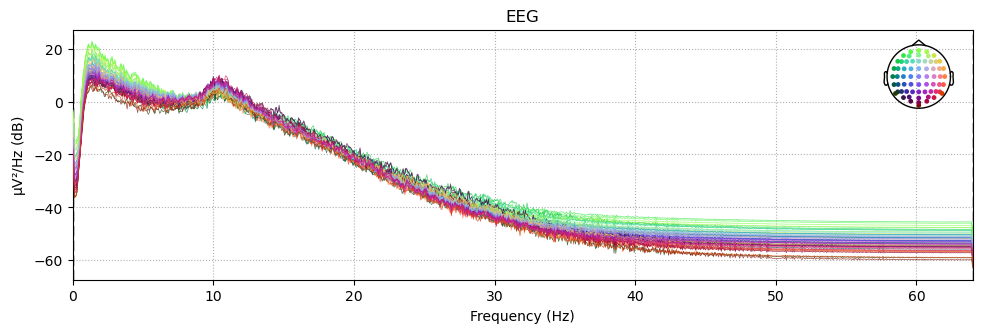

In [78]:
raw.info['bads'] = [] 
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)


## ICA

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/2909299708.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 44.8s.


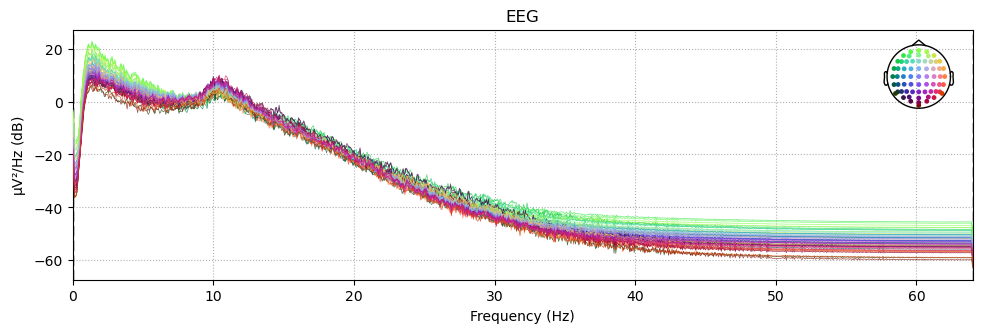

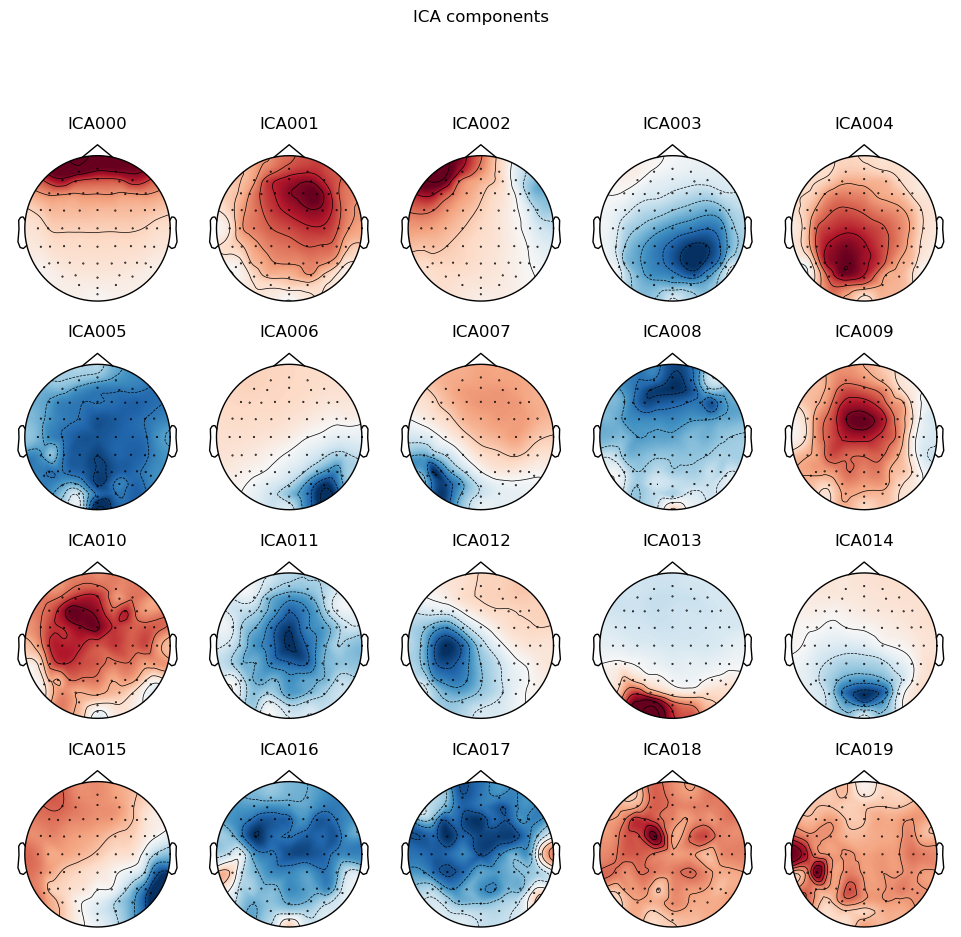

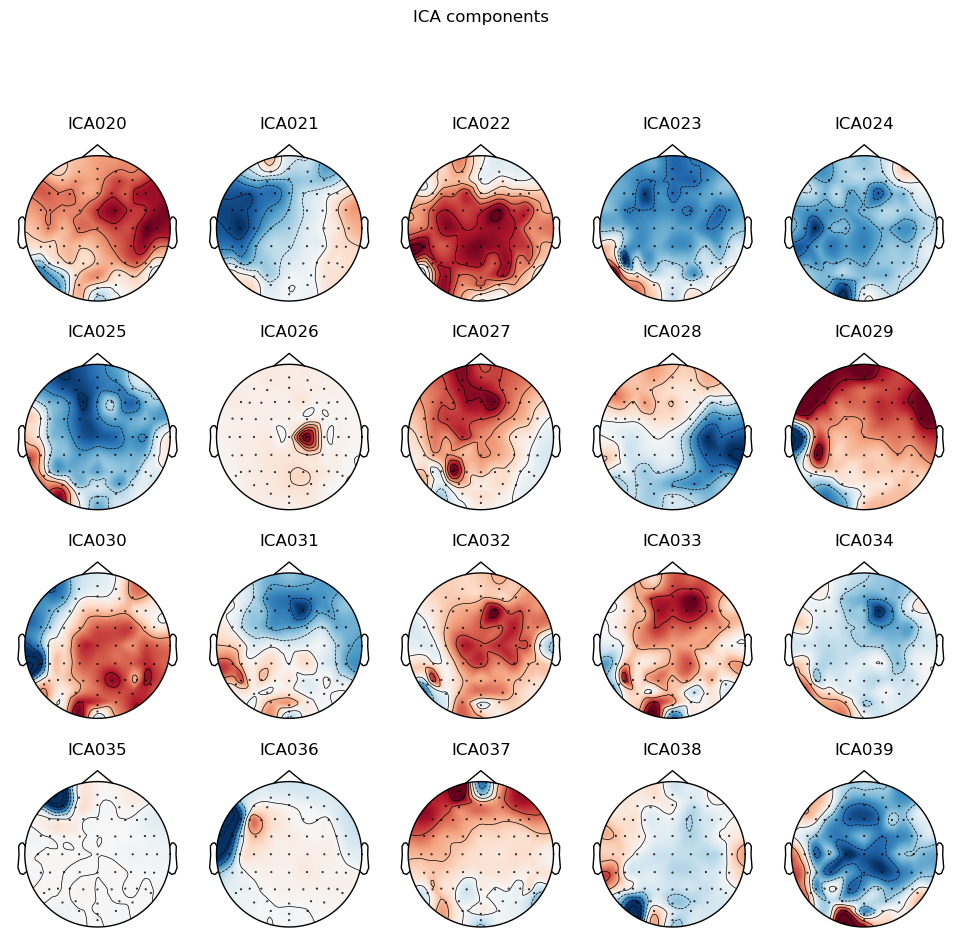

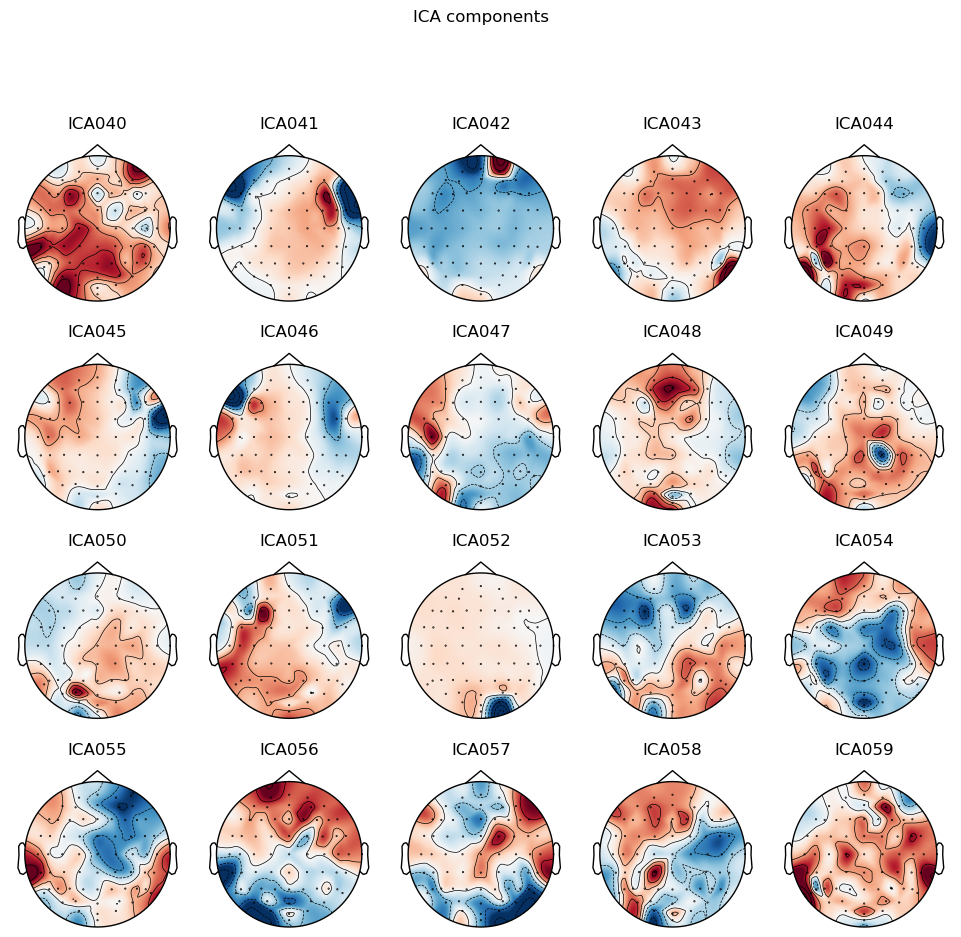

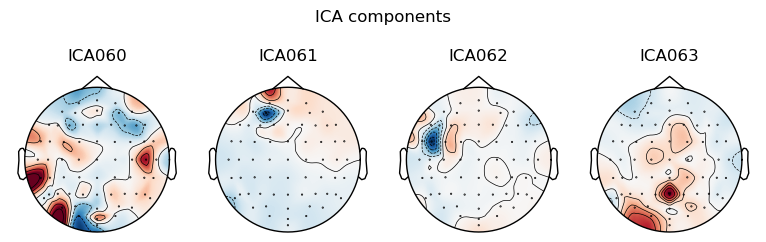

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 780x260.5 with 4 Axes>]

In [79]:
ica = ICA(max_iter='auto', random_state=97)
ica.fit(raw)

ica.plot_components()

#ICA components over time
#ica.plot_sources(raw)

In [80]:
#exclude components based on correlation to eog
#eog_indices, eog_scores = ica.find_bads_eog(raw)
#ica.exclude = eog_indices

#manually select components if eog not available

ica.exclude = [0]

#reconstruct raw
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

## PLOTS

All keystroke ERPs

Not setting metadata
322 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 322 events and 91 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


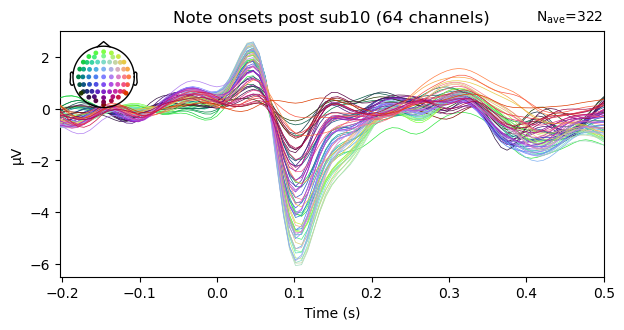

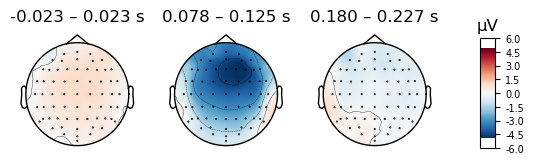

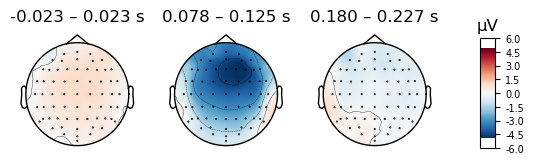

In [81]:
events_arr = make_raw_events(events_sv)
if keystroke_trigs == 'MIDI' and task == 'motor':
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==6])
else:
    t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
epochs = mne.Epochs(reconst_raw, t_keystrokes, tmin=-0.2, tmax=0.5, preload=True)
#fig = epochs.plot(events=t_keystrokes)
evoked = epochs.average()
evoked.plot(titles = f'Note onsets {period} sub{subject_ID}')

evoked.plot_topomap(times=[0,0.1, 0.2], average=0.05)

In [82]:
reject_criteria = dict(
    
    eeg=100e-6,  # 100 µV

)  # 100 µV
epochs.drop_bad(reject=reject_criteria)
print(epochs.drop_log)

    Rejecting  epoch based on EEG : ['AF7', 'F7']
    Rejecting  epoch based on EEG : ['C2']
    Rejecting  epoch based on EEG : ['C2']
3 bad epochs dropped
((), (), (), (), ('AF7', 'F7'), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ('C2',), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()

Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


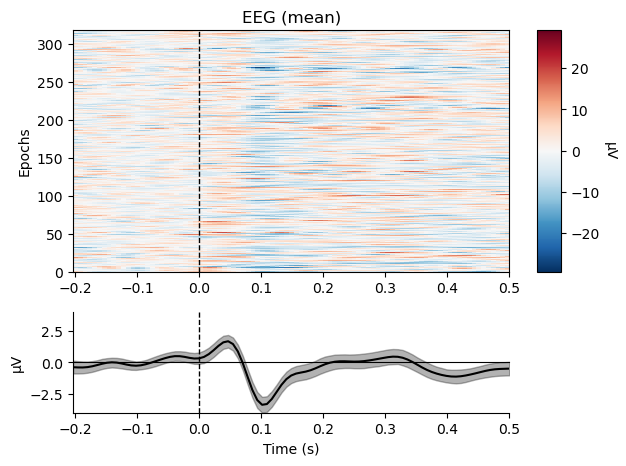

[<Figure size 640x480 with 3 Axes>]

In [83]:
mne.viz.plot_epochs_image(epochs, combine = 'mean')

In [84]:
evoked = evoked.copy().interpolate_bads(reset_bads = True)
epochs = epochs.copy().interpolate_bads(reset_bads = True)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/760160267.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  evoked = evoked.copy().interpolate_bads(reset_bads = True)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/760160267.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs = epochs.copy().interpolate_bads(reset_bads = True)


In [85]:

mne.write_evokeds(f'{evokeds_folder}/{task}_ERP_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
epochs.save(f'{epochs_folder}/{task}_epochs_{period}_{subject_ID}.fif', overwrite = overwrite)

Overwriting existing file.
Overwriting existing file.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/2549197442.py:2: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_ERP_data/listen_ERP_post_10.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  mne.write_evokeds(f'{evokeds_folder}/{task}_ERP_{period}_{subject_ID}.fif', evoked, overwrite = overwrite)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_76456/2549197442.py:3: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data/listen_epochs_post_10.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(f'{epochs_folder}/{task}_epochs_{period}_{subject_ID}.fif', overwrite = overwrite)


### Compute power

In [173]:
def compute_power(epochs, bands=['delta', 'alpha']):
    """
    Returns a DataFrame with power computed over each frequency band for given epochs.
    
    Parameters
    ----------
    epochs : mne.Epochs
        The epochs for which to compute the PSD and power.
    bands : list of str, optional
        List of frequency bands to compute power for. Default is ['delta', 'alpha'].
        
    Returns
    -------
    df : pd.DataFrame
        DataFrame where each column represents the power in a different frequency band.
    """

    freqbands = {'delta': [0.5, 4], 
                 'theta': [4, 8],
                 'alpha': [8, 12],
                 'beta': [12, 30],
                 'gamma': [30, 100]}

    
    power_dict = {}
    for key in bands:
        if key not in freqbands:
            continue  
        fmin, fmax = freqbands[key]

        psd = mne.Epochs.compute_psd(epochs, fmin=fmin, fmax=fmax)
        
        psd_ave_64 = psd.average() #average over epochs
        psd_ave = np.mean(psd_ave_64.get_data(), axis = 0) #average over channel

        #integrate PSD
        power = np.trapz(psd_ave)

        # save PSD
        power_dict[key] = power


    df = pd.DataFrame([power_dict])

    return df


In [174]:
res = compute_power(epochs, bands = ['alpha'])

    Using multitaper spectrum estimation with 7 DPSS windows


In [177]:
res

,alpha
0,3.916081e-10


In [227]:
psd = mne.Epochs.compute_psd(epochs, 
                             method = 'welch',
                             fmin =12, 
                             fmax = 30, 
                             tmin = 0, 
                             tmax = 0.2)
psd

Effective window size : 0.211 (s)


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,319
Dims,"epoch, channel, freq"
Estimation method,welch
Number of channels,64
Number of frequency bins,4
Frequency range,14.22 – 28.44 Hz


Averaging across epochs...


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


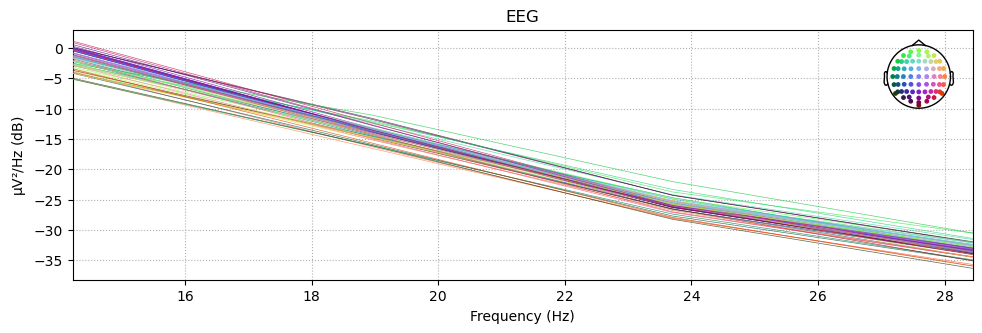

In [228]:
psd.plot()

Averaging across epochs...


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


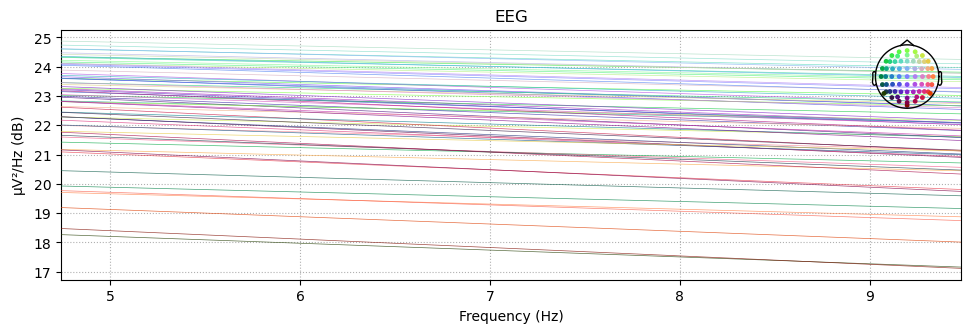

In [181]:
psd.plot()

In [156]:
for band in freqbands.keys():
    fmin = freqbands[key][0]
    fmax = freqbands[key][1]
    psd = mne.Epochs.compute_psd(epochs, fmin =8, fmax = 12)
    psd_ave_64 = psd.average() #average over epochs
    psd_ave = np.mean(psd_ave_64.get_data(), axis = 0)
   # psd_ave.save(f'psd_{task}_{subject}')


    Using multitaper spectrum estimation with 7 DPSS windows


In [158]:
np.trapz(psd_ave)

3.916081329839027e-10

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


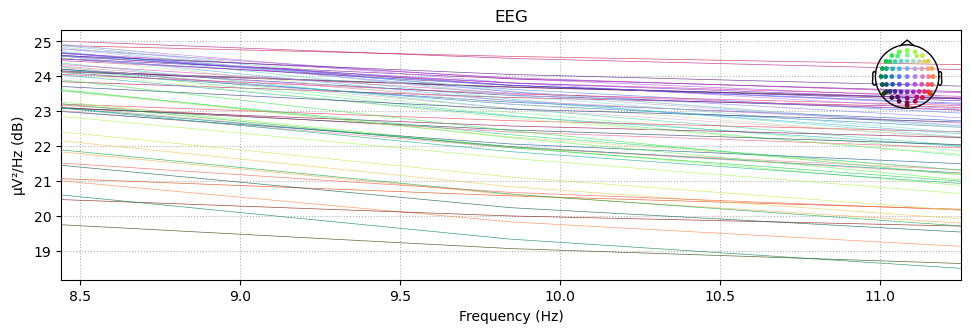

In [141]:
psd_ave.plot() #plot the PSD
#psd_ave.plot_topomap() #plots topomap of different freq bands

In [89]:
"""t_evokeds = dict(
        #cue=list(epochs['cue'].iter_evoked()),
        non_error=list(epochs.iter_evoked()))
mne.viz.plot_compare_evokeds(t_evokeds, combine = 'mean')"""

"t_evokeds = dict(\n        #cue=list(epochs['cue'].iter_evoked()),\n        non_error=list(epochs.iter_evoked()))\nmne.viz.plot_compare_evokeds(t_evokeds, combine = 'mean')"

In [90]:
"""t_evokeds = dict(
        #cue=list(epochs['cue'].iter_evoked()),
        keystroke=list(epochs.iter_evoked()))
mne.viz.plot_compare_evokeds(t_evokeds, picks = 'Cz', combine = 'mean')"""

"t_evokeds = dict(\n        #cue=list(epochs['cue'].iter_evoked()),\n        keystroke=list(epochs.iter_evoked()))\nmne.viz.plot_compare_evokeds(t_evokeds, picks = 'Cz', combine = 'mean')"